In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## NN, Downsample train, NAICS only, Data Generator Randomize
In the downsampled data, use the custom data generator to inject 20% random cases for each batch.  This is to help the model learn to handle unseen codes.  But downsample the training data to examine the 

Use only the base NAICS in the model. 

Custom data generators are used to retrieve data at each batch or epoch, and can be used to modify data for every batch or epoch.  In future scripts, I modify at the batch level, injecting random "1" values.   See also  https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/utils/Sequence

Use the dataset with no missing values. 

*This script takes about 15 minutes on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from keras.callbacks import EarlyStopping

In [6]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model
from sba_nn.sba_nn.sbnn_model import CatInjectGenerator

## Input Data

In [7]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('20_DATA_downsamp_train.parquet'))

In [8]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [9]:
with open(Path(setup.temp_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)

##### Features

In [10]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [11]:
# NAICS feature
features_naics = ['NAICS']
features_naics_max_levels  = [naics_max_levels[n] for n in features_naics]
features_naics_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_naics]

In [12]:
print(features_naics_max_levels)
print(features_naics_emb_dim)

[1170]
[8]


##### Datasets for train, validation

In [13]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric + features_naics].set_index('LoanNr_ChkDgt').sort_index()

In [14]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (44684, 11), y:(44684,)


In [15]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 11), y:(95604,)


In [16]:
base_thresh = y_train.mean()
print(base_thresh)

0.20295855339718916


## Create, fit model

In [17]:
this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         features_naics_max_levels,
                                         features_naics_emb_dim,
                                         naics_embedding_names = features_naics,
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)

2024-05-20 13:47:53.624760: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-20 13:47:53.624833: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-20 13:47:53.624849: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-20 13:47:53.624911: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-20 13:47:53.624944: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
this_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_naics_00 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 emb_naics_00 (Embedding)    (None, 1, 8)                 9360      ['input_naics_00[0][0]']      
                                                                                                  
 NAICS (Flatten)             (None, 8)                    0         ['emb_naics_00[0][0]']        
                                                                                                  
 input_numeric (InputLayer)  [(None, 10)]                 0         []                        

##### Use data generator to inject 1 values into training data

In [19]:
generator = CatInjectGenerator(X_train, y_train,
                               categorical_columns=features_naics,
                               batch_size = setup.nn_batch_size,
                               injection_rate = 0.2,
                               injection_value = 1)

In [20]:
callback = keras.callbacks.EarlyStopping(patience=3)

In [21]:
this_history = this_model.fit(generator,
                              batch_size=setup.nn_batch_size,
                              epochs = setup.nn_epochs,
                              validation_data=([X_val[features_numeric]] + [X_val[f] for f in features_naics], 
                                               y_val),
                              shuffle=True,
                             callbacks=[callback])

Epoch 1/20


2024-05-20 13:47:54.638834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1396/1397 [============================>.] - ETA: 0s - loss: 0.4826 - auc: 0.2904 - auc_1: 0.6559

2024-05-20 13:48:25.460335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1397/1397 [==============================] - 62s 43ms/step - loss: 0.4825 - auc: 0.2903 - auc_1: 0.6560 - val_loss: 0.4640 - val_auc: 0.3356 - val_auc_1: 0.7012
Epoch 2/20
1397/1397 [==============================] - 61s 43ms/step - loss: 0.4681 - auc: 0.3273 - auc_1: 0.6899 - val_loss: 0.4635 - val_auc: 0.3435 - val_auc_1: 0.7052
Epoch 3/20
1397/1397 [==============================] - 71s 51ms/step - loss: 0.4625 - auc: 0.3378 - auc_1: 0.7022 - val_loss: 0.4623 - val_auc: 0.3507 - val_auc_1: 0.7075
Epoch 4/20
1397/1397 [==============================] - 73s 52ms/step - loss: 0.4601 - auc: 0.3489 - auc_1: 0.7070 - val_loss: 0.4603 - val_auc: 0.3503 - val_auc_1: 0.7074
Epoch 5/20
1397/1397 [==============================] - 72s 51ms/step - loss: 0.4574 - auc: 0.3508 - auc_1: 0.7114 - val_loss: 0.4635 - val_auc: 0.3526 - val_auc_1: 0.7089
Epoch 6/20
1397/1397 [==============================] - 70s 50ms/step - loss: 0.4564 - auc: 0.3538 - auc_1: 0.7143 - val_loss: 0.4600 - val_auc: 0.3542

In [22]:
this_history_df = sbnn_model.process_history(this_history)

In [23]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('22_REPORT_fit_history.csv'))

<Axes: >

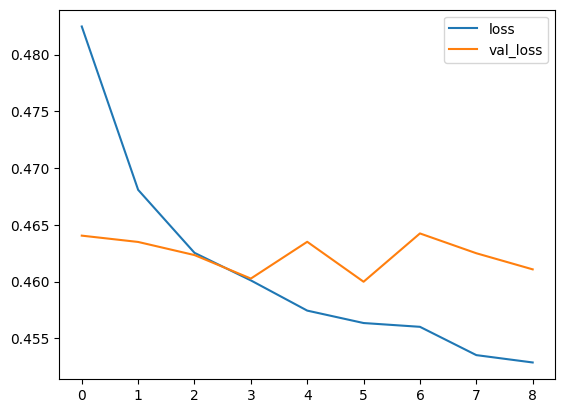

In [24]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

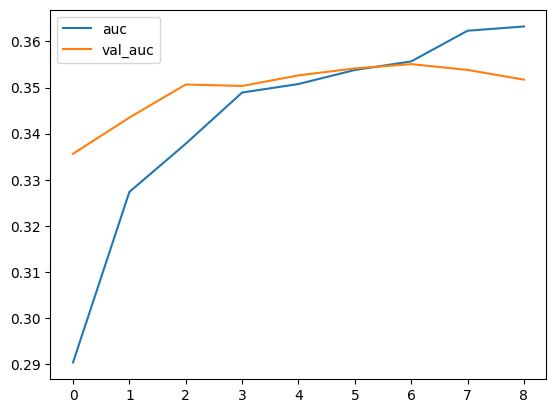

In [25]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

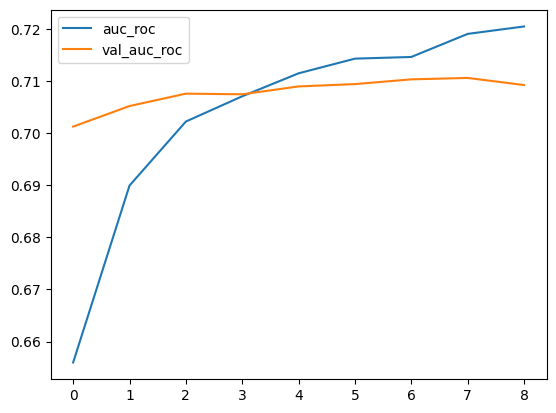

In [26]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [27]:
this_model.save(Path(setup.temp_path).joinpath('22_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [28]:
all_predictions = this_model.predict([X[features_numeric]]+ [X[f] for f in features_naics])

  75/9167 [..............................] - ETA: 18s

2024-05-20 13:57:40.192202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9167/9167 [==============================] - 20s 2ms/step


In [29]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
           on='LoanNr_ChkDgt')

In [30]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.296102
target,0.296102,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [31]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [32]:
thresh_tune_data = sbnn_metrics.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [33]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
12,0.24,0.458146
13,0.26,0.457759
11,0.22,0.457019


In [34]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.24

##### Append binary predictions to probability predictions

In [35]:
all_predictions_df['predict_bin'] = sbnn_metrics.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [36]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.541321
1    0.458679
Name: proportion, dtype: float64

In [37]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('22_DATA_predictions.parquet'))

## Metrics

In [38]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('22_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.623295,0.432662,0.310728,0.712102,0.343205,0.706757,NaN
1,train,0.644213,0.458146,0.331557,0.741096,0.392524,0.740170,NaN
2,val,0.628164,0.435847,0.315490,0.704675,0.351842,0.709251,NaN
0,test,0.628149,0.433710,0.314017,0.700850,0.349950,0.706464,0.0
1,test,0.615227,0.430971,0.305529,0.731169,0.339131,0.710802,1.0
